> This is a rework of my task during Deep Learning class in 2022.

> Goal(s):
- to construct a Back Propagation Neural Network (BPNN) architecture to help determine whether a transaction is fraudulent or not based on the given dataset, as instructed steps.
- adjust the model architecture to achieve maximum accuracy.

> Requirement(s):
- the baseline architecture for the Back Propagation Neural Network (BPNN) includes an input layer with $n$ nodes, two hidden layers with $2 × n$ nodes each, and an output layer with number of class nodes, where each layer uses the ReLU activation function to enhance learning efficiency.

> Reference(s):
1.  https://www.scribbr.com/statistics/correlation-coefficient/
2.  https://www.researchgate.net/publication/286813143_Diagnosis_of_breast_cancer_by_modular_neural_network#pf2

# Import Essentials

## Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Dataset

In [3]:
data = pd.read_csv('../dataset/creditcard.csv')
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,0
4,NaN,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,0


In [4]:
def split_dataset(x, y, size, state=np.random.randint(0, 100)):
  data_A_X, data_B_X, data_A_Y, data_B_Y = train_test_split(x, y, train_size=size, random_state=state, stratify=y)
  data_A = pd.concat([data_A_X, data_A_Y], axis=1)
  data_B = pd.concat([data_B_X, data_B_Y], axis=1)
  return data_A, data_B

# Data Overview

In [5]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,0
4,NaN,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284802 non-null  float64
 1   V2      284803 non-null  float64
 2   V3      284801 non-null  float64
 3   V4      284800 non-null  float64
 4   V5      284801 non-null  float64
 5   V6      284802 non-null  float64
 6   V7      284802 non-null  float64
 7   V8      284801 non-null  float64
 8   V9      284799 non-null  float64
 9   V10     284802 non-null  float64
 10  Class   284807 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 23.9 MB


In [7]:
numvar_col = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']

> Based on this information, it can be concluded that there are missing values since this dataset is not all equal by count.

In [8]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
count,284802.000000,2.848030e+05,284801.000000,284800.000000,284801.000000,284802.000000,284802.000000,284801.000000,284799.000000,284802.000000,284807.000000
mean,0.000013,7.430608e-07,-0.000028,-0.000011,0.000002,-0.000007,-0.000003,-0.000011,-0.000003,-0.000008,0.001727
std,1.958699,1.651318e+00,1.516254,1.415866,1.380261,1.332276,1.237102,1.194359,1.098643,1.088855,0.041527
min,-56.407510,-7.271573e+01,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,0.000000
25%,-0.920356,-5.985499e-01,-0.890375,-0.848639,-0.691604,-0.768296,-0.554080,-0.208633,-0.643108,-0.535436,0.000000
50%,0.018110,6.546722e-02,0.179832,-0.019848,-0.054332,-0.274204,0.040088,0.022356,-0.051429,-0.092926,0.000000
75%,1.315645,8.037342e-01,1.027167,0.743328,0.611927,0.398558,0.570441,0.327346,0.597152,0.453898,0.000000
max,2.454930,2.205773e+01,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,1.000000


> There are also quite a few outliers in the dataset. Hence, adjustments between column values are needed to prevent significant disparities. 

In [9]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

> It can also be seen that this dataset is imbalanced.

# Handling Missing/Error Value

> In this dataset, the independent variables are numerical. Several methods can be employed to address missing values, such as dropping the affected rows. However, opting to drop rows with missing values is avoided because it reduces the dataset size and leads to a loss of information from other filled columns. For instance, dropping row 1 due to a missing value in column 2 would result in losing valuable data from the other populated columns.

In [10]:
data.isnull().sum()

V1       5
V2       4
V3       6
V4       7
V5       6
V6       5
V7       5
V8       6
V9       8
V10      5
Class    0
dtype: int64

> To address missing value issues, KNNImputer from the scikit-learn library will be utilized. This method employs the KNN algorithm to estimate missing values by calculating the mean of the nearest samples.

In [11]:
imputer = KNNImputer(n_neighbors=5)
data = imputer.fit_transform(data)

In [12]:
data = pd.DataFrame(data, columns=numvar_col+['Class'])
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,0.0
4,-1.403725,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,0.0


In [13]:
data.isnull().sum()

V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
V8       0
V9       0
V10      0
Class    0
dtype: int64

> Hence, there is no more missing value found on this dataset.

> Dividing the raw data into training and testing sets using a 4:1 ratio.

In [14]:
data_train, data_test = split_dataset(data.drop(columns='Class'), data['Class'], 0.8, 21)

# Handling Imbalance Dataset

> Imbalanced dataset often results in a good, or even nearly perfect accuracy score. The information obtained from the majority class is abundant, while the information from the minority class is very limited, or vice versa. This imbalance in information and data makes it difficult for the model to accurately predict the true class of a given data point.

> To address this issue, oversampling (equalizing the number of minority class data with that of the majority) will be performed rather than undersampling (equalizing the number of majority class data with that of the minority) because the number of minority class in this dataset is significantly lesser than the number of majority class.

> In this case, Synthetic Minority Oversampling Technique (SMOTE) will be utilized.

In [15]:
data_train['Class'].value_counts()

Class
0.0    227451
1.0       394
Name: count, dtype: int64

In [16]:
SMOTE = SMOTE(random_state=27)

In [17]:
def handling_imbalance_dataset(data, columns_name, col_target):
  x = pd.DataFrame(data, columns=columns_name)
  y = pd.DataFrame(data, columns=[col_target])
  x, y = SMOTE.fit_resample(x, y)
  data = pd.DataFrame(data=np.column_stack((x, y)), columns=data_test.columns)
  return data

In [18]:
data_train = handling_imbalance_dataset(data_train, data_train.columns[:-1], 'Class')
data_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,-0.568089,0.223634,2.784809,1.398554,-0.976417,1.181462,-0.350213,0.544987,0.184840,-0.298910,0.0
1,1.005389,-0.382836,1.280514,1.682977,-0.950041,0.752944,-0.764272,0.535072,1.297392,-0.189560,0.0
2,-3.633303,-1.481175,0.094030,-0.287921,-0.630724,0.531253,1.667692,-0.881678,3.188153,0.232909,0.0
3,-0.111852,0.255704,1.589792,-0.007662,-0.400043,0.183738,-0.123587,-0.053031,1.720502,-1.091077,0.0
4,-3.063601,2.554788,-0.294903,-1.092867,-0.770817,-0.987801,-0.270569,0.883005,1.513483,0.350049,0.0


In [19]:
data_train['Class'].value_counts()

Class
0.0    227451
1.0    227451
Name: count, dtype: int64

> Hence, the issue of dataset imbalance has been resolved for now.

# Exploratory Data Analysis (EDA)

> Outliers are data points that are distant in value from other data points. Outliers need to be removed to avoid negatively impacting the model's performance (such as accuracy in predictions and other metrics).

> Outlier removal will be conducted before feature selection because outliers affect correlation (the relationship between variables) during feature selection.

In [20]:
def visualize_numvar(df, col_names, col_target, type):
  data = df[col_names]
  rows = np.ceil((len(data.columns)) / 2).astype(int)
  fig, axs = plt.subplots(rows, 2, figsize=(10, 10))
  axs = axs.flatten()
  for idx, col_name in enumerate(col_names):
    if(type == 'dist'):
      sns.histplot(data[col_name], ax=axs[idx], kde=True)
      axs[idx].set_title(f"Distribution Plot ({col_name})")
    elif(type == 'box'):
      sns.boxplot(x=df[col_target], ax=axs[idx])
      axs[idx].set_title(f"Box Plot ({col_name})")
    elif(type == 'grouped-box'):
      sns.boxplot(y=df[col_name], x=df[col_target], ax=axs[idx])
      axs[idx].set_title(f"Box Plot ({col_name})")
    elif(type == 'scatter'):
      sns.scatterplot(x=df[col_target], y=data[col_name], ax=axs[idx])
      axs[idx].set_title(f"Scatter Plot ({col_name})")
  plt.tight_layout()
  plt.show()

## Distribution Plot

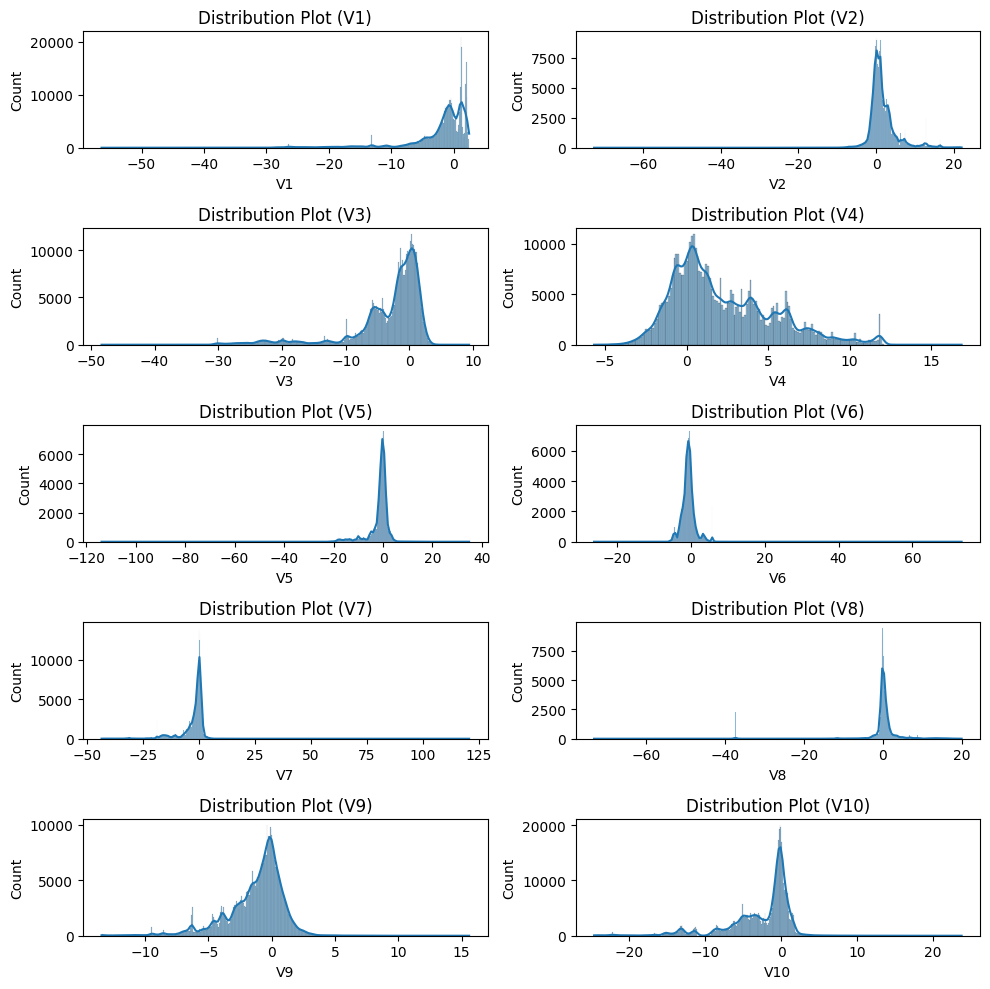

In [21]:
visualize_numvar(data_train, numvar_col, 'Class', 'dist')

## Box Plot

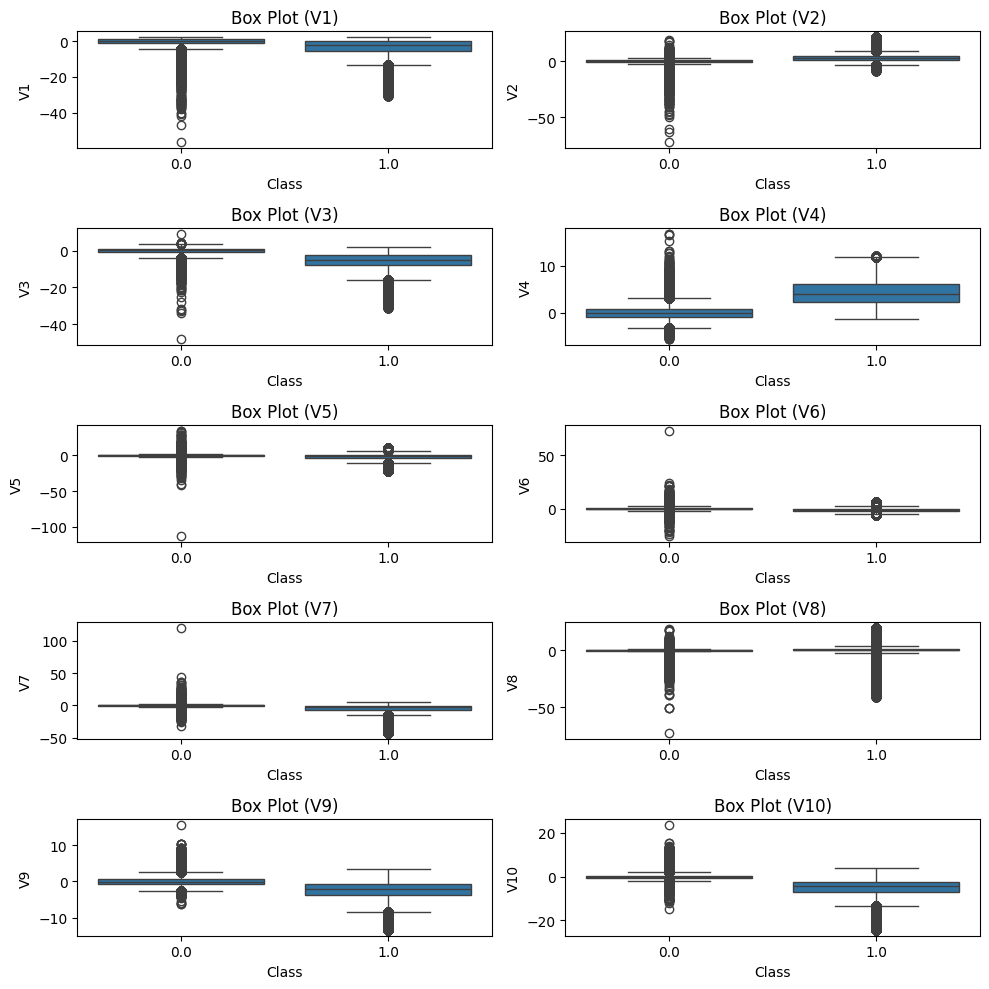

In [22]:
visualize_numvar(data_train, numvar_col, 'Class', 'grouped-box')

In [23]:
data_train = data_train[data_train['V1'] > -4]
data_train = data_train[data_train['V2'] > -3]
data_train = data_train[data_train['V2'] < 3]
data_train = data_train[data_train['V3'] > -5]
data_train = data_train[data_train['V5'] > -2]
data_train = data_train[data_train['V5'] < 2]
data_train = data_train[data_train['V6'] > -3]
data_train = data_train[data_train['V6'] < 3]
data_train = data_train[data_train['V7'] > -3]
data_train = data_train[data_train['V7'] < 3]
data_train = data_train[data_train['V8'] > -2]
data_train = data_train[data_train['V8'] < 2]
data_train = data_train[data_train['V9'] > -2]
data_train = data_train[data_train['V9'] < 2]
data_train = data_train[data_train['V10'] > -2]
data_train = data_train[data_train['V10'] < 5]

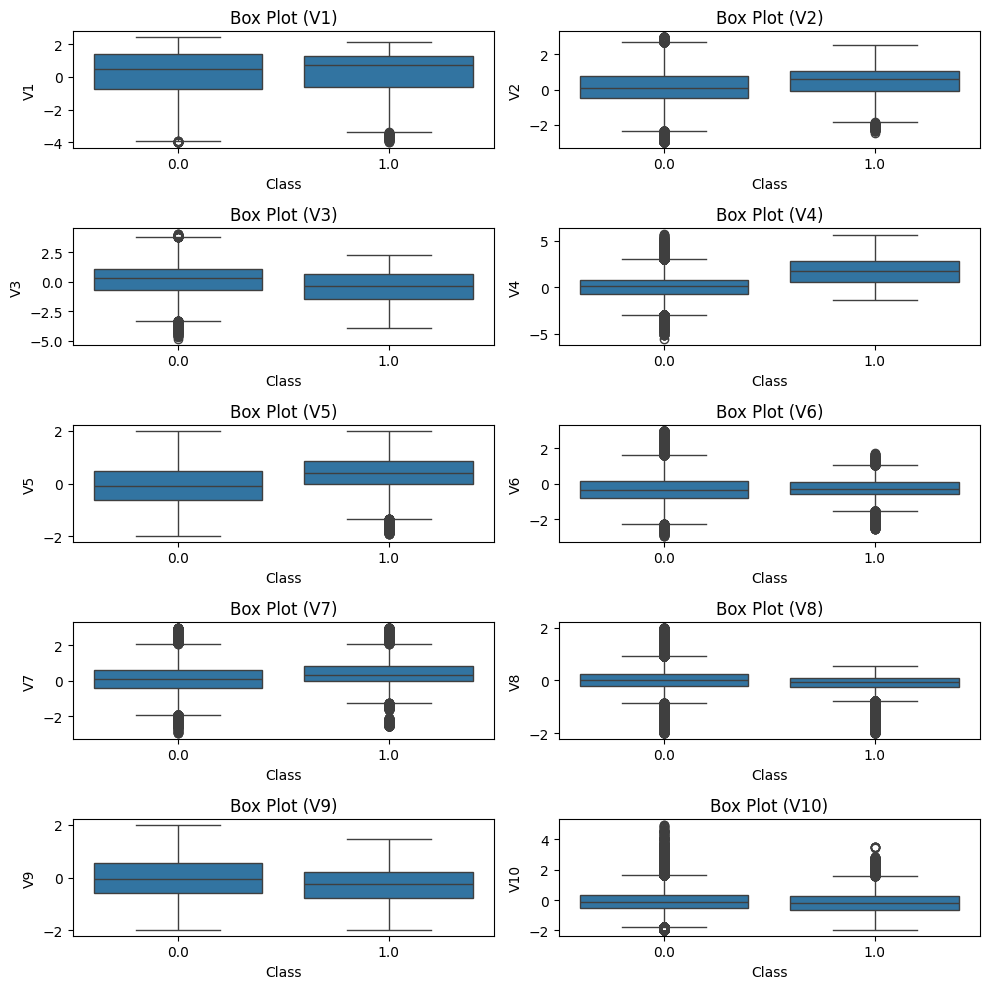

In [24]:
visualize_numvar(data_train, numvar_col, 'Class', 'grouped-box')

> After the removal of outliers, since the dataset was initially imbalanced, a check on the dataset needed to be performed again.

In [25]:
data_train['Class'].value_counts()

Class
0.0    180506
1.0     32346
Name: count, dtype: int64

> Upon reevaluation, it can be seen that the dataset became imbalanced once more. The removed outliers had significantly skewed one class, leading to this issue. Hence, oversampling needed to be reimplemented.

In [26]:
data_train = handling_imbalance_dataset(data_train, data_train.columns[:-1], 'Class')
data_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,-0.568089,0.223634,2.784809,1.398554,-0.976417,1.181462,-0.350213,0.544987,0.184840,-0.298910,0.0
1,1.005389,-0.382836,1.280514,1.682977,-0.950041,0.752944,-0.764272,0.535072,1.297392,-0.189560,0.0
2,-0.111852,0.255704,1.589792,-0.007662,-0.400043,0.183738,-0.123587,-0.053031,1.720502,-1.091077,0.0
3,-3.063601,2.554788,-0.294903,-1.092867,-0.770817,-0.987801,-0.270569,0.883005,1.513483,0.350049,0.0
4,-1.355695,1.219515,-0.743743,0.780160,1.011600,-0.076846,-0.313639,0.932184,-0.993451,-0.886951,0.0


In [27]:
data_train['Class'].value_counts()

Class
0.0    180506
1.0    180506
Name: count, dtype: int64

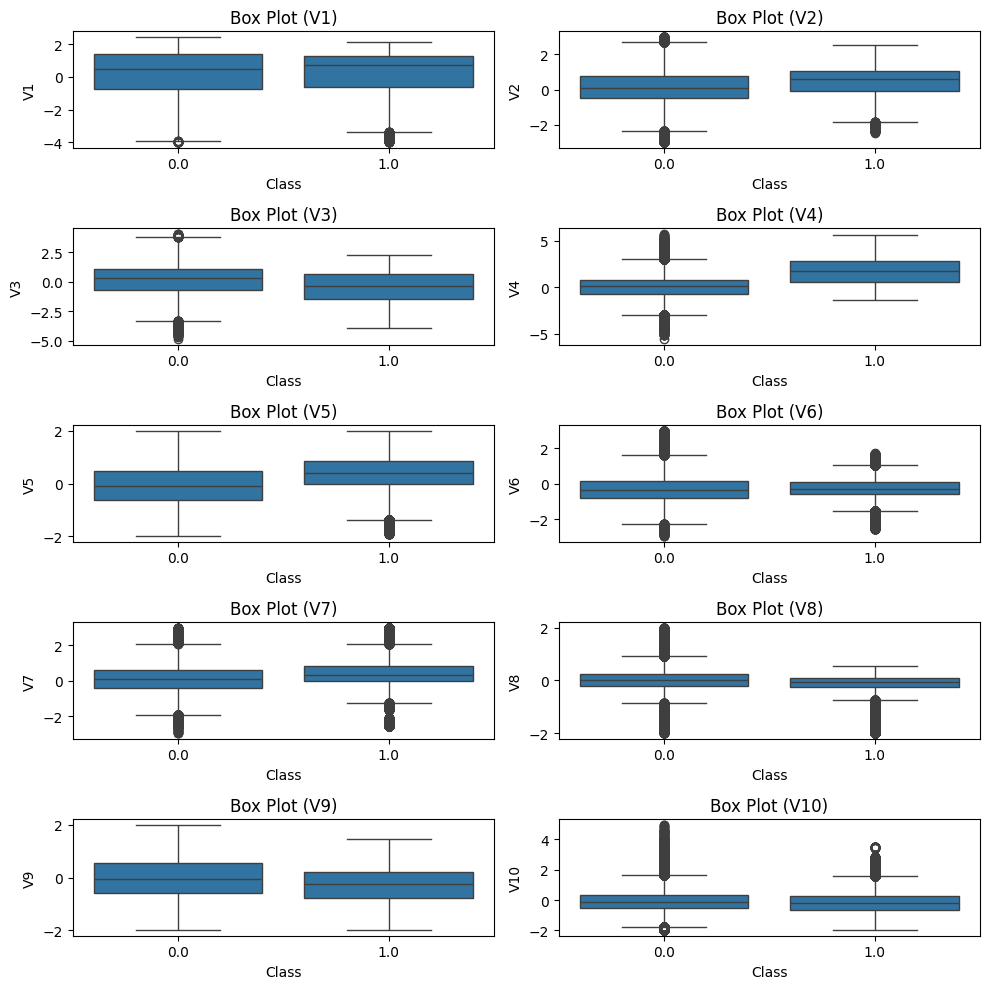

In [28]:
visualize_numvar(data_train, numvar_col, 'Class', 'grouped-box')

> It can be seen from this visualization that the outliers in most columns have been removed,  leading to a reduced number of outliers and an overall improvement in the results.

## Correlation Analysis

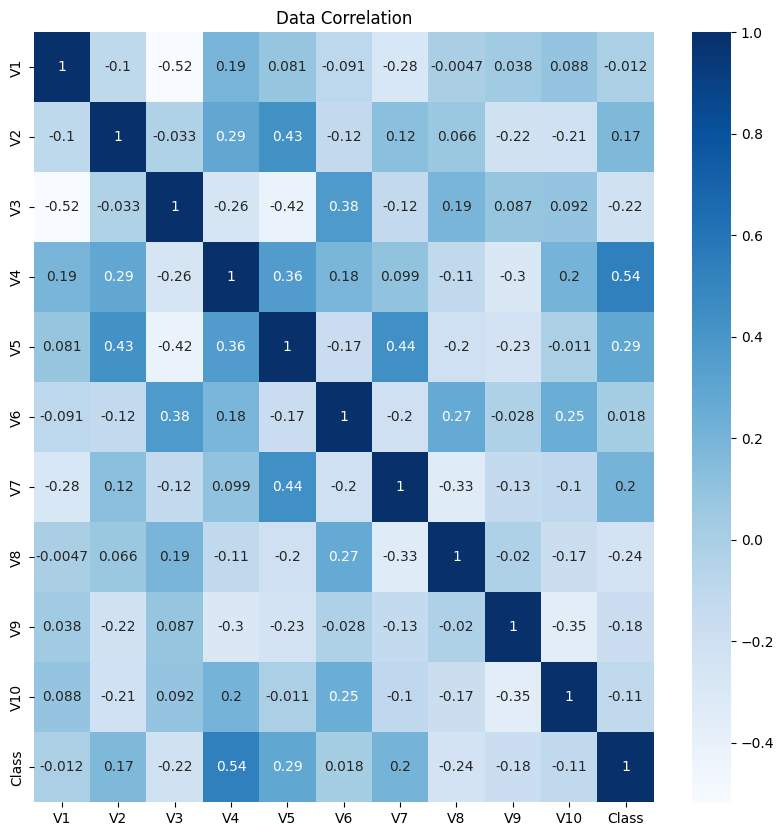

In [29]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_train.corr(), cmap='Blues', annot=True) 
plt.title('Data Correlation')
plt.show()

> It's noteworthy that the correlation between the independent variables and dependent variable ranges from 0.024 to 0.55, which indicate a weak to moderate relationship [1]. Furthermore, since the dataset columns labeled merely as "V1", "V2", etc. without any further context, in my opinion, it is necessary to include all columns.

# Feature Transformation

> Feature Transformation is essential before proceeding to the next stages because the dataset contains a mix of positive and negative values across different features. While the range of values for each feature is not excessively wide, the variability in scales can still impact model performance. Standardization is most effective when the dataset follows a Gaussian distribution (bell curve), whereas normalization is a suitable approach when the distribution is unknown or not Gaussian.

> Normalization using MinMaxScaler is beneficial as it rescales all features to a consistent range of [0, 1]. This uniformity helps ensure that no single feature disproportionately influences the model, which is particularly important for neural networks that are sensitive to the scale of input data. Given these considerations, normalization using MinMaxScaler has been chosen as the appropriate transformation method for this dataset.

In [30]:
scalar = MinMaxScaler()

In [31]:
data_train[numvar_col] = scalar.fit_transform(data_train[numvar_col])
data_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,0.531591,0.537430,0.855827,0.615339,0.255895,0.694725,0.439784,0.636643,0.546208,0.243772,0.0
1,0.775397,0.436309,0.688270,0.640345,0.262491,0.622730,0.370538,0.634162,0.824353,0.259443,0.0
2,0.602283,0.542777,0.722719,0.491710,0.400018,0.527098,0.477684,0.487005,0.930133,0.130246,0.0
3,0.144917,0.926120,0.512791,0.396303,0.307306,0.330269,0.453103,0.721222,0.878377,0.336776,0.0
4,0.409553,0.703481,0.462796,0.560973,0.753002,0.483318,0.445900,0.733528,0.251627,0.159499,0.0


# Data Splitting

> Dividing the testing data into testing and validation sets using a 1:1 ratio.

In [32]:
data_test, data_valid = split_dataset(data_test.drop(columns='Class'), data_test['Class'], 0.5, 1)

In [33]:
x_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values
x_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values
x_valid = data_valid.iloc[:, :-1].values
y_valid = data_valid.iloc[:, -1].values

In [34]:
np.bincount(y_train.astype(int))

array([180506, 180506], dtype=int64)

In [35]:
np.bincount(y_train.astype(int))

array([180506, 180506], dtype=int64)

> Untuk memudahkan modeling pada tahap selanjutnya, dataset yang telah disiapkan dan dibagi digabungkan dengan DataLoader.

In [36]:
class Dataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __getitem__(self, index):
    x = torch.Tensor(self.x[index])
    y = torch.LongTensor([int(self.y[index])])
    return x, y

  def __len__(self):
    return len(self.x)

In [37]:
train_ds = Dataset(x_train, y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=0, drop_last=True)

valid_ds = Dataset(x_valid, y_valid)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False, num_workers=0, drop_last=True)

test_ds = Dataset(x_test, y_test)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, drop_last=True)

# Model Building

> A Back Propagation Neural Network (BPNN) is composed of an input layer, one or more hidden layers, and an output layer. Each neuron in the hidden layer receives inputs from the neurons in the input layer, processes these inputs, and passes the results to the next layer. Ultimately, the processed information reaches the output layer. The output generated may contain some error, which is used to adjust the weights in order to minimize this error during training. [2]

> 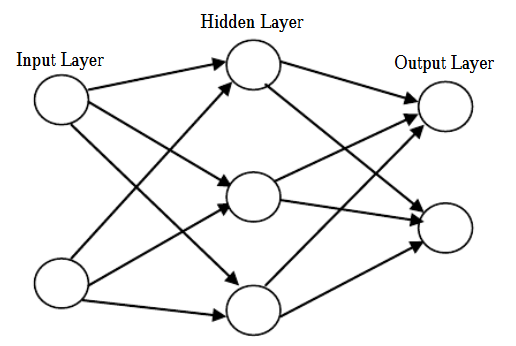

In [38]:
nnodes = data_train.shape[1]-1
num_class = data_train['Class'].unique().shape[0]

In [37]:
class BPNN(nn.Module):
  def __init__(self):
    super(BPNN, self).__init__()
    self.fc1 = nn.Linear(nnodes, nnodes)
    self.hidden1 = nn.Linear(nnodes, 2 * nnodes)
    self.hidden2 = nn.Linear(2 * nnodes, num_class)

  def forward(self, X):
    X = self.fc1(X)
    X = F.relu(X)
    X = self.hidden1(X)
    X = F.relu(X)
    X = self.hidden2(X)
    return X

In [57]:
model = BPNN()
print(model)

BPNN(
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (hidden1): Linear(in_features=10, out_features=20, bias=True)
  (hidden2): Linear(in_features=20, out_features=2, bias=True)
)


> The model will use Cross Entropy as the loss function to measure the difference between predicted outputs and actual labels, ideal for classification tasks. Stochastic Gradient Descent (SGD) will be the optimizer, updating weights based on mini-batches of data for efficient learning. Multiple learning rates will be tested to control the size of weight updates, helping to balance convergence speed and stability during the training of the Backpropagation Neural Network (BPNN).

In [39]:
criterion = nn.CrossEntropyLoss()
learning_rates = [0.1, 0.3, 0.5]

## Training and Validation

> Once the model is prepared, the training and validation process is conducted over 25 iterations using the model and both training and validation datasets that have been prepared. First, the model is trained on the provided dataset to generate outputs. Then, the loss is calculated using the criterion, which employs CrossEntropy loss. After determining the loss, the optimizer is used to adjust the model parameters, with the goal of reducing the loss in subsequent iterations. During the validation phase, the model that achieves the lowest mean validation loss is retained for future testing.

In [40]:
def train_valid_crossval(train_loader, valid_loader, epochs, learning_rates, isUseExistingModel, model_name):
  train_mean_losses = []
  valid_mean_losses = []

  if isUseExistingModel:
    model.load_state_dict(torch.load(model_name))
    print("Loaded existing model weights.")

  for lr in learning_rates:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    print("=========================================================")
    print(f"Learning Rate: {lr}")
    for i in range(epochs):
      train_losses = []
      print("=========================================================")
      print(f"Epoch {i+1}")
      for batch_data in train_loader:
        x, y = batch_data
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss)
      train_mean_loss = torch.mean(torch.stack(train_losses))
      print('Training Loss: {:10.8f}'.format(train_mean_loss))
      train_mean_losses.append(train_mean_loss.detach().numpy())
        
      valid_losses = []
      with torch.set_grad_enabled(False):
        for batch_data in valid_loader:
          x, y = batch_data
          out = model(x)
          loss = criterion(out, y.squeeze())
          valid_losses.append(loss)
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('Validation Loss: {:10.8f}'.format(valid_mean_loss))
        valid_mean_losses.append(valid_mean_loss)

      if (i == epochs - 1):
        torch.save(model.state_dict(), f"{model_name}_{lr}.pth")
  return train_mean_losses, valid_mean_losses

In [41]:
epochs = 25
train_mean_losses, valid_mean_losses = train_valid_crossval(train_loader, valid_loader, epochs, learning_rates, False, "bpnn-model")

Learning Rate: 0.1
Epoch 1
Training Loss: 0.00760930
Validation Loss: 6.18072701
Epoch 2
Training Loss: 0.00933268
Validation Loss: 5.83801031
Epoch 3
Training Loss: 0.00762546
Validation Loss: 5.71431684
Epoch 4
Training Loss: 0.00701555
Validation Loss: 5.70152855
Epoch 5
Training Loss: 0.00672262
Validation Loss: 5.70113325
Epoch 6
Training Loss: 0.00654749
Validation Loss: 5.73866987
Epoch 7
Training Loss: 0.00642505
Validation Loss: 5.74214363
Epoch 8
Training Loss: 0.00635476
Validation Loss: 5.74658775
Epoch 9
Training Loss: 0.00630823
Validation Loss: 5.76985645
Epoch 10
Training Loss: 0.00625098
Validation Loss: 5.78644371
Epoch 11
Training Loss: 0.00622685
Validation Loss: 5.81836176
Epoch 12
Training Loss: 0.00620974
Validation Loss: 5.85320854
Epoch 13
Training Loss: 0.00619390
Validation Loss: 5.87272644
Epoch 14
Training Loss: 0.00618466
Validation Loss: 5.90065813
Epoch 15
Training Loss: 0.00620636
Validation Loss: 5.92514610
Epoch 16
Training Loss: 0.00618866
Validation

In [41]:
def show_result(type, train_mean_results, valid_mean_results, epochs, learning_rates):
  for idx in range(len(learning_rates)):
    plt.plot(range(1, epochs + 1), train_mean_results[idx * epochs:(idx + 1) * epochs], label=f'Train {type} (LR={learning_rates[idx]})')
    plt.plot(range(1, epochs + 1), valid_mean_results[idx * epochs:(idx + 1) * epochs], label=f'Valid {type} (LR={learning_rates[idx]})', linestyle='--')

  plt.xlabel('Epochs')
  plt.ylabel(type)
  plt.title(f'Train and Validation {type}')
  plt.legend()
  plt.show()

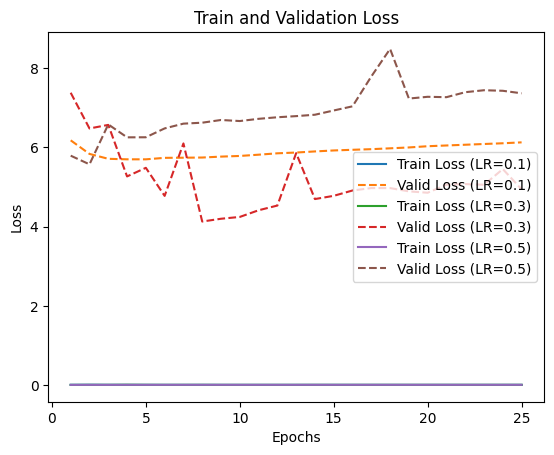

In [43]:
show_result('Loss', train_mean_losses, valid_mean_losses, epochs, learning_rates)

> The results indicate that the model demonstrates effective learning across different learning rates, with a learning rate of 0.3 yielding the best training and validation loss, showing a constant and stable decrease, suggesting optimal performance and generalization. However, it is essential to note that the testing dataset has not yet been evaluated, making it crucial to assess the model's performance in real-world scenarios before drawing definitive conclusions about its effectiveness and robustness.

In [58]:
model.load_state_dict(torch.load("bpnn-model_0.3.pth"))

<All keys matched successfully>

## Testing

In [42]:
def test(test_loader):
  test_predictions = np.empty((0, 2))
  with torch.no_grad():
    for batch_data in test_loader:
      x, y = batch_data
      out = model(x)
      test_predictions = np.append(test_predictions, out.numpy(), axis=0)
  return test_predictions

In [60]:
test_predictions = test(test_loader)
test_predictions = np.argmax(np.array(test_predictions), axis=1)

In [61]:
result_comparation = pd.DataFrame({
    'y prediction': test_predictions,
    'y ground truth': y_test[:len(test_predictions)]
})
result_comparation.head()

,y prediction,y ground truth
0,1,0.0
1,1,0.0
2,1,0.0
3,0,0.0
4,1,0.0


In [43]:
def result_score(y_test, y_pred):
  print("Confusion Matrix:")
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
  plt.show()
  print("\nAccuracy Score: %lf" % (accuracy_score(y_test, test_predictions)))
  print("Precision Score: %lf" % (precision_score(y_test, test_predictions)))
  print("Recall Score: %lf" % (recall_score(y_test, test_predictions)))
  print("F1 Score: %lf" % (f1_score(y_test, test_predictions)))
  print("\nClassification Report:\n%s" % (classification_report(y_test, test_predictions)))

Confusion Matrix:


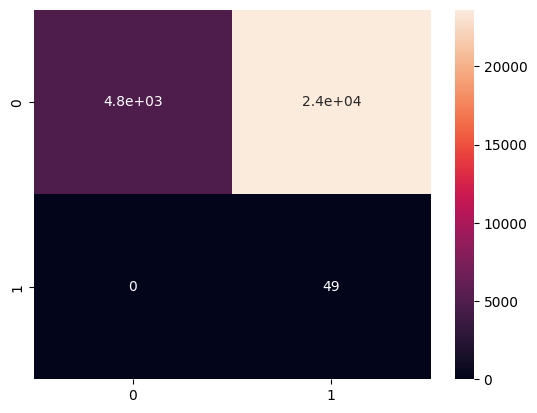


Accuracy Score: 0.170365
Precision Score: 0.002070
Recall Score: 1.000000
F1 Score: 0.004130

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.29     28431
         1.0       0.00      1.00      0.00        49

    accuracy                           0.17     28480
   macro avg       0.50      0.58      0.15     28480
weighted avg       1.00      0.17      0.29     28480



In [63]:
result_score(result_comparation['y ground truth'], result_comparation['y prediction'])

> This evaluation reveals that the model achieves a low overall accuracy score of approximately 17.03%. Although the model theoretically achieves a recall score of 1.0 for class 1.0 (indicating that it would correctly identify all instances if it were to predict them), it fails to make any predictions for this class, resulting in a precision score of 0.0. In contrast, the model excels at identifying the majority class (class 0.0), achieving a precision score of 1.0 but with a significantly low recall of only 17.0%. This disparity indicates substantial overfitting, as the model has learned to predict the majority class effectively while neglecting the minority class entirely. The F1 score for class 1.0 is particularly concerning at 0.004, where the model fails to learn the distinguishing features of this class adequately.

> To improve the model's performance, several strategies can be implemented. First, enhancing the architecture by adding more layers or filters may help the model learn more complex features. Additionally, experimenting with different activation functions could improve learning efficiency. Regularization techniques like dropout or L2 regularization can help prevent excessive complexity.

# Architecure Improvement

> Improving the Architecture to achieve maximum accuracy (by adding or reducing architecture, changing hyperparameters, or utilizing hyperparameter tuning).

## Training and Validation

> In this model improvement experiment, an increase in architecture will be implemented. This is done because the model faces significant challenges in effectively classifying the minority class and shows signs of overfitting. Therefore, it has been decided to enhance the architecture so that the model can better capture the distinguishing features between both classes and improve its overall performance by implementing strategies such as simplifying the network structure, experimenting with different activation functions, applying regularization techniques like dropout.

In [ ]:
class BPNN_1(nn.Module):
  def __init__(self):
    super(BPNN_1, self).__init__()
    self.fc1 = nn.Linear(nnodes, 2 * nnodes)
    self.hidden1 = nn.Linear(2 * nnodes, 4 * nnodes)
    self.hidden2 = nn.Linear(4 * nnodes, num_class)

    self.dropout = nn.Dropout(0.5)

  def forward(self, X):
    X = self.fc1(X)
    X = F.relu(X)
    X = self.dropout(X)
    X = self.hidden1(X)
    X = F.relu(X)
    X = self.dropout(X)
    X = self.hidden2(X)
    return X

In [45]:
model = BPNN_1()
print(model)

BPNN_1(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (hidden1): Linear(in_features=20, out_features=40, bias=True)
  (hidden2): Linear(in_features=40, out_features=2, bias=True)
  (batch_norm1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


> The model will still use Cross Entropy as the loss function and Stochastic Gradient Descent (SGD) as the optimizer. Multiple learning rates will be tested to control the size of weight updates, helping to balance convergence speed and stability during the training of the Backpropagation Neural Network (BPNN).

In [46]:
epochs = 25
train_mean_losses, valid_mean_losses = train_valid_crossval(train_loader, valid_loader, epochs, learning_rates, False, "bpnn-model-1")

Learning Rate: 0.1
Epoch 1
Training Loss: 0.01111011
Validation Loss: 10.44258404
Epoch 2
Training Loss: 0.02122255
Validation Loss: 10.68478394
Epoch 3
Training Loss: 0.02677551
Validation Loss: 9.71869850
Epoch 4
Training Loss: 0.03020158
Validation Loss: 10.35862255
Epoch 5
Training Loss: 0.02859648
Validation Loss: 9.82625198
Epoch 6
Training Loss: 0.02426555
Validation Loss: 9.06097889
Epoch 7
Training Loss: 0.02075441
Validation Loss: 9.24111748
Epoch 8
Training Loss: 0.01626814
Validation Loss: 8.87807846
Epoch 9
Training Loss: 0.01558375
Validation Loss: 9.52855968
Epoch 10
Training Loss: 0.01553537
Validation Loss: 9.36369419
Epoch 11
Training Loss: 0.01566172
Validation Loss: 8.90243435
Epoch 12
Training Loss: 0.01772599
Validation Loss: 9.21882248
Epoch 13
Training Loss: 0.01636800
Validation Loss: 9.94603252
Epoch 14
Training Loss: 0.01725573
Validation Loss: 9.25075722
Epoch 15
Training Loss: 0.01630057
Validation Loss: 8.61816120
Epoch 16
Training Loss: 0.01426331
Validat

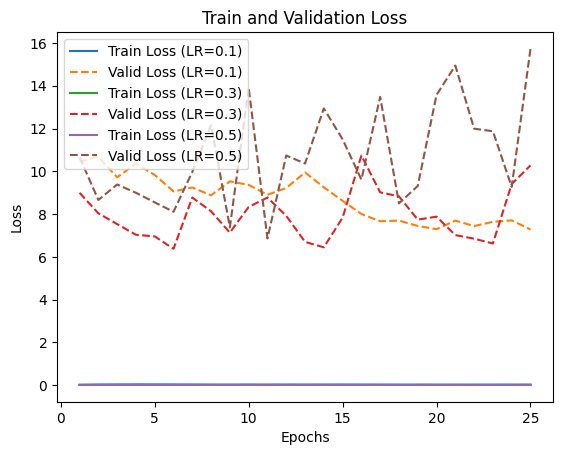

In [47]:
show_result('Loss', train_mean_losses, valid_mean_losses, epochs, learning_rates)

> The results indicate that the model demonstrates effective learning across different learning rates. Among the tested learning rates, the lowest validation loss was achieved when using a learning rate of 0.1, suggesting optimal performance and generalization.

In [48]:
model.load_state_dict(torch.load("bpnn-model-1_0.1.pth"))

<All keys matched successfully>

## Testing

In [49]:
test_predictions = test(test_loader)
test_predictions = np.argmax(np.array(test_predictions), axis=1)

In [50]:
result_comparation = pd.DataFrame({
    'y prediction': test_predictions,
    'y ground truth': y_test[:len(test_predictions)]
})
result_comparation.head()

,y prediction,y ground truth
0,1,0.0
1,1,0.0
2,1,0.0
3,0,0.0
4,1,0.0


Confusion Matrix:


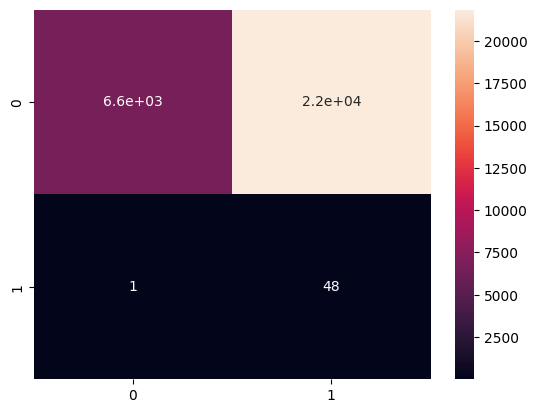


Accuracy Score: 0.232725
Precision Score: 0.002192
Recall Score: 0.979592
F1 Score: 0.004374

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.23      0.38     28431
         1.0       0.00      0.98      0.00        49

    accuracy                           0.23     28480
   macro avg       0.50      0.61      0.19     28480
weighted avg       1.00      0.23      0.38     28480



In [51]:
result_score(result_comparation['y ground truth'], result_comparation['y prediction'])

> This evaluation indicates that the model achieves a commendable accuracy score of approximately 23.3%. Despite this low accuracy, it demonstrates a concerning classification performance characterized by a perfect precision score of 1.0 for the majority class (class 0.0), while exhibiting a significantly low recall of only 23.0%. This suggests that, although the model correctly identifies all instances it predicts as class 0.0, it fails to capture a substantial portion of actual instances of this class. In contrast, for the minority class (class 1.0), the model achieves a high recall score of approximately 97.96%, indicating that it would correctly identify nearly all instances if it were to predict them; however, it does not make any predictions for this class, resulting in a precision score of 0.0.

> These performance metrics highlight significant issues despite balancing the dataset with SMOTE, indicating potential overfitting to the majority class. The F1 score for class 1.0 is particularly troubling at 0.004, underscoring the model's failure to learn the distinguishing features necessary for effective classification of this class. Overall, these results emphasize the need for further strategic improvements, such as exploring different algorithms or adjusting model architecture, to enhance the model's ability to generalize and improve performance across both classes.